In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks'); sns.set_palette("deep")
from pprint import pprint

In [2]:
# import data
data = pd.read_csv('clean_data.csv', parse_dates=['Occurred', 'Reported'], converters={'Coordinates':eval})
data.head()

,Unnamed: 0,Incident,Comments,Reported,Coordinates,Occurred
0,0,lost,woman reports losing a canon power shot digita...,2010-07-01 12:42:00,"(41.7892236, -87.5980197)",2010-06-28 19:45:00
1,5,lost,staff member reports losing wallet containing ...,2010-07-01 23:09:00,"(41.66861859999999, -87.7841447)",2010-07-02 03:00:00
2,72,lost,patient's cell phone missing after she transfe...,2010-07-18 19:19:00,"(41.7892116, -87.60406619999999)",2010-07-18 19:00:00
3,111,lost,patient reports a hp computer missing after sh...,2010-07-24 19:07:00,"(41.7892116, -87.60406619999999)",2010-07-24 16:00:00
4,122,lost,patient reports loss of eye glasses,2010-07-25 13:41:00,"(41.7892116, -87.60406619999999)",2010-07-23 17:00:00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4155 entries, 0 to 4154
Data columns (total 6 columns):
Unnamed: 0     4155 non-null int64
Incident       4155 non-null object
Comments       4155 non-null object
Reported       4152 non-null datetime64[ns]
Coordinates    4155 non-null object
Occurred       2187 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 194.8+ KB


In [4]:
def DayOrNight(df, lat, long):
    '''
    Function takes a DataFrame containing a NumPy datetime64 type column
    and a set of GPS coordinates.
    Returns a list of 1s and 0s indicating day and night respectively.
    '''
    day_night = []  
    for i in df.dropna().index:
        date = str(df.Occurred.dt.date[i])
        time = df.Occurred.dt.time[i]
        r = requests.get('https://api.sunrise-sunset.org/json?lat={}&lng={}&date={}&formatted=0'.format(lat, long, date),\
                         timeout=1)
        
        if r.status_code == requests.codes.ok:
            info = r.json()
            #pprint(info)
            day_info = pd.to_datetime(pd.Series(info['results']), utc=True).dt.tz_convert('US/Central')
            
            if (time < day_info.dt.time['sunrise']) | (time > day_info.dt.time['sunset']):
                day_night.append(0)  # night = 0
                
            else:
                day_night.append(1)  # day = 1
        
        else:
            day_night.append(np.nan)
            print('A wild NaN appeared! at ', i)
        
    return pd.DataFrame([df.dropna().index, day_night]).T

In [5]:
# hyde park coordinates
lat, long = 41.7943, -87.5907

# uncomment to extract data from sunrise-sunset API
#day = DayOrNight(data, lat, long)

# load data from previous extract
day = pd.read_csv('day_night.csv', index_col=['0'])
print(day.columns)

Index(['Unnamed: 0', '1'], dtype='object')


In [6]:
# save file
#day.to_csv('day_night.csv')

day.rename(columns={'Unnamed: 0': 'idx', '1':'day'}, inplace=True)
print(day.columns)

# add day column
data['day'] = np.nan
data.update(day['day'])
data.rename(columns={'day': 'day_or_night'}, inplace=True)

Index(['idx', 'day'], dtype='object')


In [7]:
# add day_name and year
data['day_name'] = data.Reported.dt.day_name()
data['year'] = data.Reported.dt.year

In [8]:
# add time spaced column
start = data.Occurred[0]
one_year = np.timedelta64(1, 'Y')
data['normalize_year'] = (data.Occurred - start) / one_year

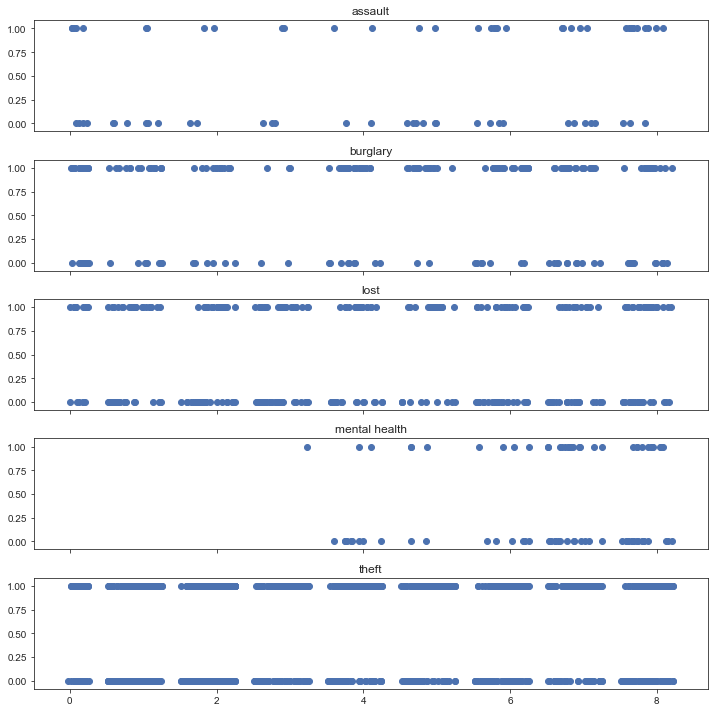

In [9]:
group_incident = data.groupby('Incident')

fig, axes = plt.subplots(5, figsize=(10, 10), sharex=True)
i = 0
for title, report in group_incident:
    axes[i].scatter(report.normalize_year, report.day_or_night)
    axes[i].set_title(title)
    i += 1
    
plt.tight_layout()

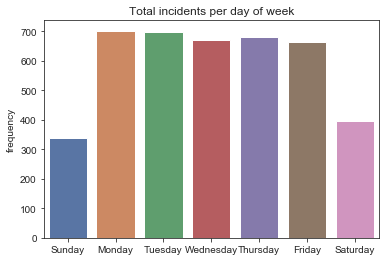

In [17]:
dayofweek = ['Sunday', 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday','Saturday']

days_plot = sns.barplot(dayofweek, group_incident.Reported.apply(lambda x: x.dt.day_name()).value_counts()[dayofweek])
days_plot.set_ylabel('frequency')
days_plot.set_title('Total incidents per day of week')

#plt.savefig('total_incidents_per_dayofweek.png')
plt.show()


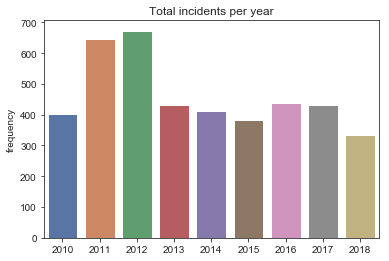

In [18]:
years = [y for y in range(2010, 2019)]
all_incidents = sns.barplot(years, group_incident.Reported.apply(lambda x: x.dt.year).value_counts()[years])
all_incidents.set_ylabel('frequency')
all_incidents.set_title('Total incidents per year')

#plt.savefig('total_incidents_per_year.png')
plt.show()

/Users/olivaspepe/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


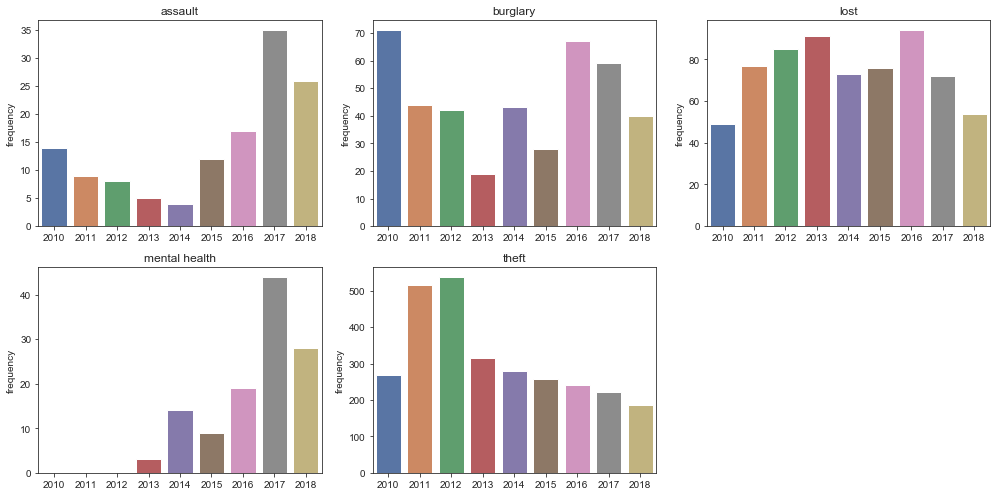

In [19]:
years = [y for y in range(2010, 2019)]
grouped = data.groupby('Incident')


##### plotting #####
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.ravel()
fig.delaxes(axes[-1])

for ax, key in zip(axes, grouped.groups.keys()):
    sns.barplot(years, grouped.get_group(key)['year'].value_counts().loc[years], ax=ax)
    ax.set_ylabel('frequency')
    ax.set_title(key)
    
plt.tight_layout()
# uncomment to save
#plt.savefig('total_occurred_per_incident.png')

In [20]:
def format_dict_barplot(dictionary):
    """
    Parameters:
    dictionary - nested dictionary from day_night_count_per_year() function
    
    Returns:
    bar - DataFrame w/ columns = [year, values, time]
        year - year incident occurred
        values - count of incident
        time - day or night label
    
    E.g     year values time 
            2010    4    1
            2010    5    0
    """
    
    years, values  = [], []
    for year, vals in dictionary.items():
        for v in vals:
            values.append(v)
            years.append(year)
        
    bar = pd.DataFrame([years, values, ['day', 'night'] * (len(years) // 2)]).T
    bar.rename(columns={0: 'year', 1: 'values', 2: 'time'}, inplace=True)
    
    return bar

In [21]:
def day_night_count_per_year(df, incident_type=None):
    """
    Parameters:
    df - pandas DataFrame containing a year and day_or_night column
    incident_type - string of crime/incident of interest  e.g. 'theft'
    
    Returns: 
    A dictionary w/ the number of reported incidents that occurred
    during the day and night, respectively, for a given year.
    
    E.g. {key:value} = {2010: [4, 5]} 
    In 2010, 9 incidents occurred 4 during the day and 5 at night.
    """
    
    dict_ = {}
    group = df.groupby(['year', 'day_or_night'])
    for cols, info in group:
        g = info.groupby('Incident')
        
        try:
            count = len(g.get_group(incident_type))
            
        except KeyError:
            # voids error from mental health 
            # since cases were not documented until 2013
            count = 0
        
        dict_.setdefault(cols[0], []).append(count)
        
    return format_dict_barplot(dict_)

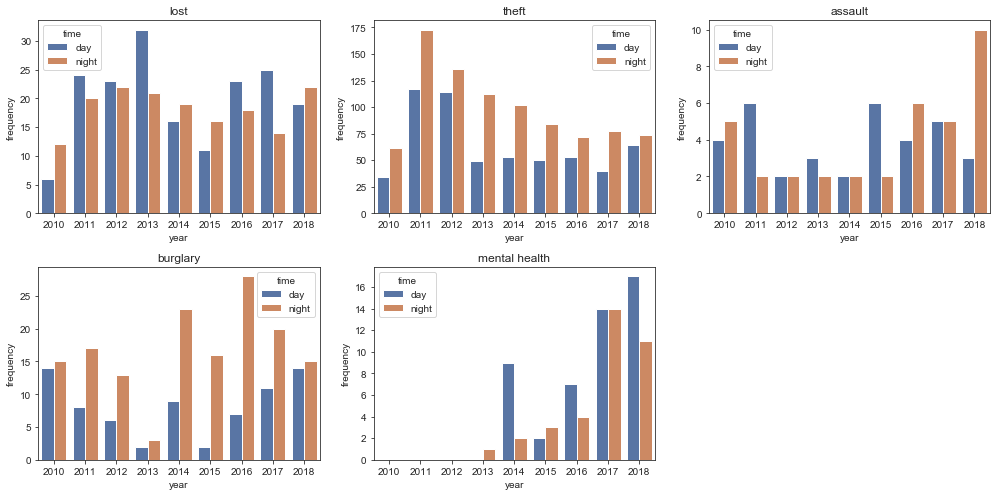

In [22]:
fig, axes = plt.subplots(2, 3, sharex=False, figsize=(14, 7))
axes = axes.ravel()
fig.delaxes(axes[-1])

names = data.Incident.unique()
for name, ax in zip(names, axes):
    foo = day_night_count_per_year(data, name)
    #ax.xticks(ticks=data.year.dropna().unique(), labels=np.linspace(2010, 2018, 9, dtype=int))
    #print(foo.values)
    #ax.bar(foo.year, foo['values'])
    sns.barplot('year', 'values', data=foo, hue='time', ax=ax)
    ax.set_xticklabels(labels=years)
    ax.set_ylabel('frequency')

    
    ax.set_title(name)
    
plt.tight_layout()
# uncomment to save
#plt.savefig('total_reported_day_night_incident.png')